#### 3-6. 프로젝트: 고양이 수염 스티커 만들기
오늘 배운 내용을 이용해서 여러분 만의 스티커를 만들고 적용해보겠습니다.


Step 1. 스티커 구하기 or 만들기

스티커를 만들거나 구해야합니다. PPT, 포토샵 등을 이용해서 직접 만드셔도 좋습니다. 보다 간단한 방법은 픽토그램 아이콘을 이용하면 쉽게 만들 수 있습니다.

고양이는 사랑스럽기 때문에 고양이 수염 스티커를 붙여보겠습니다.

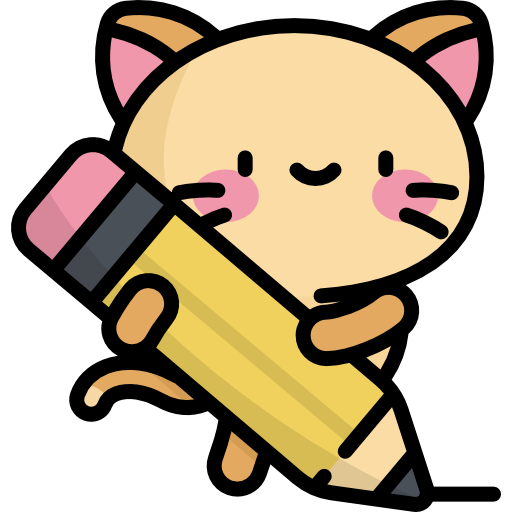

In [69]:
# 이미지 처리를 위해 opencv 와 노트북에 이미지를 
# 출력하기 위한 matplotlib를 읽어옵니다.

import cv2
import matplotlib.pyplot as plt
import numpy as np
print("🌫🛸")

🌫🛸


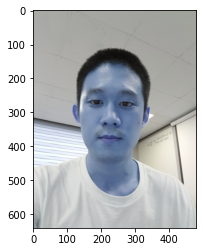

In [105]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/selfie.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480, 640))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

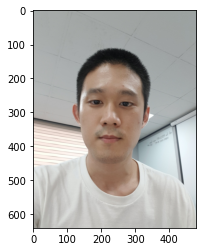

In [106]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

#### 3-3. 얼굴 검출 face detection

Object detection 기술을 이용해서 얼굴의 위치를 찾겠습니다. 이번 시간에는 빠르게 만들기 위해 학습 없이 공개되어 있는 패키지를 사용하겠습니다.

dlib의 face detector는 HOG(Histogram of Oriented Gradients) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾습니다. HOG와 SVM의 자세한 알고리즘은 아래 링크를 참고해 주세요. (한국어 버전도 있습니다.)

In [107]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


In [108]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


rectangles[[(117, 217) (340, 440)]]


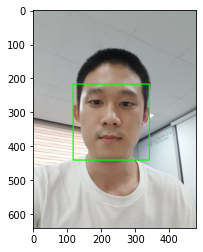

In [109]:
print(dlib_rects)   # 찾은 얼굴 영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### 3-4. 얼굴 랜드마크 face landmark


앞서 말씀 드린 것처럼 스티커를 섬세하게 적용하기 위해서는 이목구비의 위치를 아는 것이 중요합니다. 이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 합니다. face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용합니다.

##### Object keypoint estimation 알고리즘

Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 합니다. keypoint를 찾는 알고리즘은 크게 2가지로 나누어 집니다.

1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측

2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

이번 예제에서는 1번 방식을 다룹니다.

In [110]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


#### 3-5. 스티커 적용하기

이제 왕관 스티커를 머리에 씌울 준비가 되었습니다.

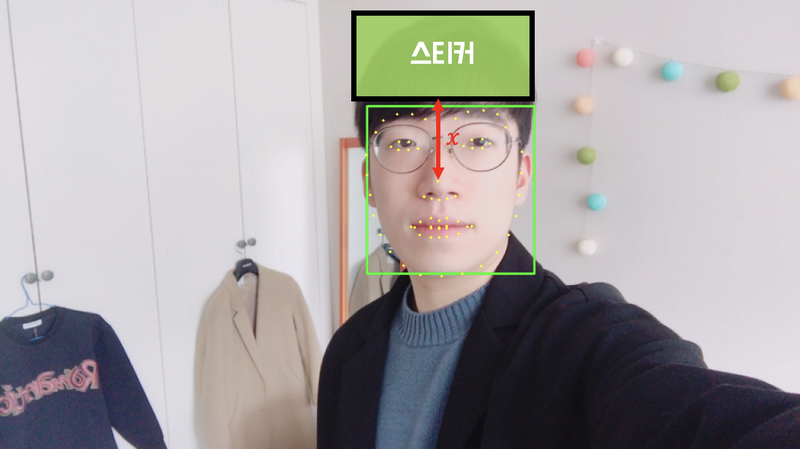

랜드마크를 기준으로 '눈썹 위 얼굴 중앙' 에 스티커를 씌우면 될 것 같습니다. 구현 방법은 여러 가지가 있습니다. 위 그림처럼 코 중심을 기준으로 높이 x 이상에 그려도 되고 눈썹 위 n 픽셀 위에 스티커를 구현해도 됩니다.

중요한 것은 얼굴 위치, 카메라의 거리에 따라 픽셀 x 가 다르기 때문에 비율로 계산을 해줘야 합니다. 계산할 수치는 두 가지 입니다.

1. 스티커 위치 

x = x_nose
y = y_nose-width/2

2. 스티커 크기

width = height = width_bbox

In [111]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있습니다. 조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환해 주었습니다. 따라서 list_points 는 tuple (x, y) 68개로 이루어진 리스트가 됩니다. 이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장됩니다.

랜드마크를 영상에 출력해 보겠습니다.

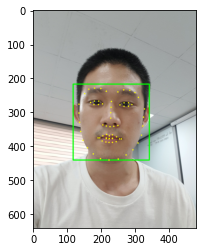

In [112]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### 3-5. 스티커 적용하기

이제 왕관 스티커를 머리에 씌울 준비가 되었습니다.

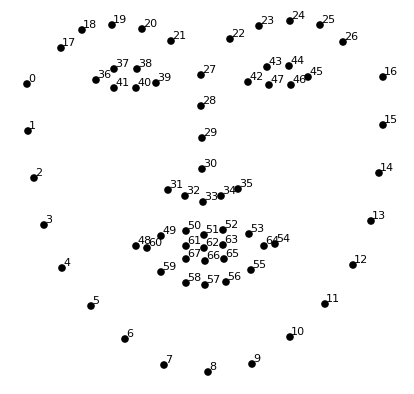

In [119]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])    # nose center index : 30
    x = landmark[30][0]     # the x-cordinate of the cat sticker
    y = landmark[30][1]     # the y-cordinate of the cat sticker
    w = (landmark[30][0] - landmark[2][0]) * 2     # width of the cat sticker
    h = (landmark[48][1] - landmark[30][1]) * 2   # height of the cat sticker
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(227, 317)
(x,y) : (227,317)
(w,h) : (182,116)


(116, 182, 3)


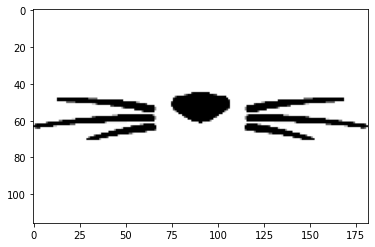

In [120]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
plt.show()

고양이 수염 이미지를 읽고 윗 단계에서 계산한 크기로 resize 합니다.

In [115]:
refined_x = x - w // 2   # left
refined_y = y - h // 2   # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (136,259)


opencv 데이터는 numpy ndarray 형태의 데이터를 사용합니다. ndarray는 음수 인덱스에 접근할 수 없기 때문에 음수에 대한 예외 처리를 해줘야 합니다. 따라서 그림에서 보시는 것처럼 원본 이미지의 범위를 벗어난 스티커 부분을 제거해 주어야 합니다.

In [116]:
if (refined_y < 0):
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
print (img_sticker.shape)

(116, 182, 3)


-y 크기만큼 스티커를 crop 합니다.

top 의 y 좌표는 원본 이미지의 경계 값으로 수정합니다.

원본 이미지에 스티커를 적용합니다.

In [117]:
# 원본 이미지에 스티커 적용하기
sticker_area = img_show[refined_y:refined_y+h, refined_x:refined_x+w]    # 원본 이미지에 스티커를 적용시킬 부분
img_show[refined_y:refined_y+h, refined_x:refined_x+w] = \
np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
# 스티커 이미지색이 255인 부분(하얀색)은 원본 이미지 색(sticker_area)을 칠하고,
# 스티커 이미지색이 255가 아닌 부분(하얀색이외의 모든색)은 스티커 이미지색(img_sticker)을 칠한다.
# (255,255,255) == 하얀색

sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다. 예제에서는 (272,0) 부터 (272+156, 0+68) 범위의 이미지를 의미합니다.

스티커 이미지에서 사용할 부분은 0 이 아닌 색이 있는 부분을 사용합니다. 따라서 np.where를 통해 img_sticker 가 0 인 부분은 sticker_area를 사용하고 0이 아닌 부분을 img_sticker를 사용하시면 됩니다. img_show 에 다시 적용하겠습니다.

결과 이미지를 출력하면,

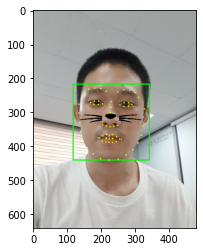

In [118]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()